# А/А-тест для данных с '2024-05-24' по '2024-05-30'

Необходимо убедиться в корректности работы системы сплитования. Для этого будем действовать по следующему алгоритму:
1. Многократно извлечем подвыборки из имеющихся данных с 2024-05-24 по 2024-05-30 для экспериментальных групп 2 и 3
2. Проведем t-test для каждой пары подвыборок и запишем полученное p value
3. Проверим в каком проценте случаев нам удалось отклонить нулевую гипотезу.

In [26]:
# Импортируем нужные библиотеки

import pandahouse
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [148]:
# Сделаем графики в seaborn покрупнее

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [18]:
# Устанавливаем параметры соединения с базой данных

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240620'
}

In [21]:
# Берем данные из базы по временному промежутку АА-теста (с 2024-05-24 по 2024-05-30)

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2024-05-24' AND '2024-05-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [74]:
# Проверим корректность подгрузки данных

print(df.head(10))

   exp_group  user_id  likes  views       ctr
0          3   115383     38    248  0.153226
1          3    10326     24    132  0.181818
2          3   123580     25    122  0.204918
3          2   131473     19     98  0.193878
4          2    23985     12     44  0.272727
5          2    24523      2     10  0.200000
6          2    24239     10     41  0.243902
7          3    19647      4     31  0.129032
8          2   127588     14     87  0.160920
9          2     6911     17    117  0.145299


In [149]:
# Определим кол-во повторов теста и размер выборки

number_of_tests = 10000
sample_size = 500

In [155]:
# Многократно выберем подвыборки без повторений размером 500 пользователей и проведем для каждой из них t-test
# Полученное p value добавим в список результатов

# H0: Подвыборки из экспериментальных групп 2 и 3 статистически эквивалентны
# H1: Подвыборки из экспериментальных групп 2 и 3 статистически значимо различаются

ttest_p_values = []

for _ in range(number_of_tests):
    ttest_p_values.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(n=sample_size).values,
                                          df[df.exp_group == 3].ctr.sample(n=sample_size).values, equal_var=False).pvalue)

<Axes: ylabel='Count'>

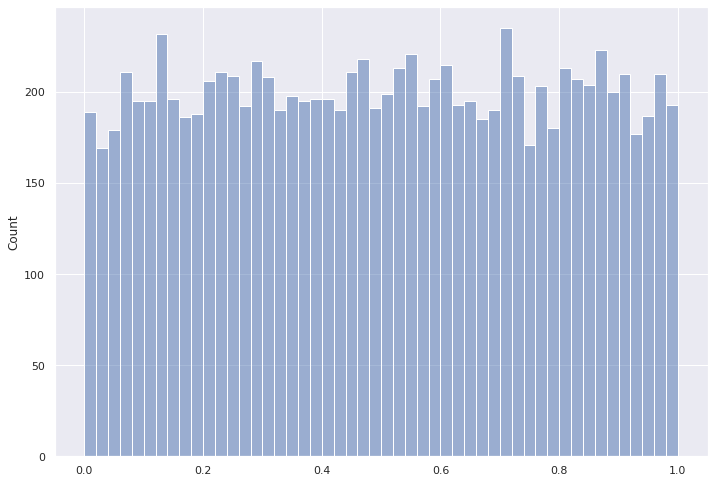

In [156]:
# Визуализируем количественные данные p value для того, чтобы рассмотреть характер распределения

sns.histplot(data = ttest_p_values, alpha=0.5, kde=False, bins=50)

**Промежуточный вывод по визуализированным результатам многократных t-тестов:**

Видим, что распределение графика +- равномерно и не имеет явного скоса в сторону p_value < 0.05. Это хороший знак, т.к. при выбранной нами точности в 0.05 и сфомулированной нулевой гипотезе о том, что подвыборки статистически эквивалентны, кол-во ложных срабатываний должно происходить не более, чем в 5% случаев.

Чтобы окончательно убедиться в правильности работы системы сплитования посчитаем какой процент прокрашиваний на самом деле.

In [157]:
# Переведем список с p-значениями в pandas.Series, т.к. это значительно облегчит процесс фильтрации данных

ttest_p_values_series = pd.Series(data=ttest_p_values, copy=True)

In [158]:
# Рассчитаем процент прокрашиваний t-критерия Стьюдента на наших подвыборках из экспериментальных групп

ttest_error_percentage = round((ttest_p_values_series.where(ttest_p_values_series <= 0.05).count() /
                          ttest_p_values_series.count()) * 100, 2)
print(f'Кол-во повторов AA-теста - {number_of_tests}')
print(f'Размер используемых выборок - {sample_size}')
print(f'Процент прокрашиваний по t-критерию Стьюдента составил: {ttest_error_percentage}%')

Кол-во повторов AA-теста - 10000
Размер используемых выборок - 500
Процент прокрашиваний по t-критерию Стьюдента составил: 4.49%


### Вывод по результатам проведения A/A-теста:

В процессе проведения А/А-теста из данных об экспериментальных группах 2 и 3 были многократно извлечены подвыборки и проведен t-test. Для визуализации результатов проведенных тестов была построена гистограмма полученных p-значений. Также был рассчитан процент случаев, в которых тест показывал наличие статистически значимого различия между подвыборками.

В результате проведенного А/А-теста, процент прокрашиваний по t-критерию Стьюдента составил 4.49%. Для выбранного уровня значимости в 0.05 и сформулированной нулевой гипотезе о статистической эквивалентности подвыборок это говорит о том, что система сплитования работает корректно, а наличие прокрашиваний может быть вызвано случайным ложным срабатыванием t-теста.